In [1]:
!pip install opencv-python

In [2]:
!pip install matplotlib

In [3]:
!pip install einops timm


In [4]:
!pip install transformers einops timm torch pillow


In [5]:
!pip install scikit-image transformers torch pillow numpy opencv-python matplotlib requests

In [6]:
!pip install torch torchvision transformers numpy opencv-python pillow matplotlib pdf2image python-docx



In [1]:
import os
import cv2
import torch
import tempfile
import pdf2image
import numpy as np
from PIL import Image
from docx import Document
import ipywidgets as widgets
from docx.shared import Inches
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
from ipyfilechooser import FileChooser
from pdf2image import convert_from_path
from docx2pdf import convert as docx2pdf_convert
from skimage.metrics import structural_similarity as ssim

In [2]:
from transformers import CLIPProcessor, CLIPModel
model_id="microsoft/Florence-2-large"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [3]:
def load_file(file_path, poppler_path=None):
    file_path = file_path.strip()
    if file_path.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        print("Loading image file:", file_path)
        return [Image.open(file_path)]
    elif file_path.lower().endswith(".pdf"):
        print("Converting PDF to images:", file_path)
        pages = convert_from_path(file_path, poppler_path=poppler_path)
        print("Converted", len(pages), "page(s) from PDF.")
        return pages
    elif file_path.lower().endswith(".docx"):
        print("Converting DOCX to PDF then to images:", file_path)
        with tempfile.TemporaryDirectory() as tmpdirname:
            print("Temporary directory created:", tmpdirname)
            # Convert DOCX to PDF; the PDF is saved in tmpdirname.
            docx2pdf_convert(file_path, tmpdirname)
            pdf_name = os.path.splitext(os.path.basename(file_path))[0] + ".pdf"
            pdf_path = os.path.join(tmpdirname, pdf_name)
            print("DOCX converted to PDF at:", pdf_path)
            pages = convert_from_path(pdf_path, poppler_path=poppler_path)
            print("Converted", len(pages), "page(s) from DOCX->PDF.")
            return pages
    else:
        raise ValueError("Unsupported file format!")

# Create two FileChooser widgets (using ipyfilechooser, not file upload)
fc1 = FileChooser()
fc1.title = "Select the first file (Image, PDF, or DOCX)"
fc2 = FileChooser()
fc2.title = "Select the second file (Image, PDF, or DOCX)"

display(fc1)
display(fc2)

# Create a button to trigger loading and displaying the files.
button = widgets.Button(description="Load and Display Files")
output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output(wait=True)
        # Check that both files are selected.
        if not fc1.selected:
            print("Please select the first file.")
            return
        if not fc2.selected:
            print("Please select the second file.")
            return

        file1 = fc1.selected
        file2 = fc2.selected
        print("File 1 selected:", file1)
        print("File 2 selected:", file2)
        
        # Specify your Poppler path (update this to match your system)
        poppler_path = r"C:\Users\ektaa\anaconda3\envs\myenv\Lib\site-packages\pdf2image\Release-24.08.0-0\poppler-24.08.0\Library\bin"
        
        # Load the files.
        pages1 = load_file(file1, poppler_path=poppler_path)
        pages2 = load_file(file2, poppler_path=poppler_path)
        
        print("\nFile 1 has", len(pages1), "page(s).")
        print("File 2 has", len(pages2), "page(s).")
        
        # Display all pages from File 1.
        print("\nDisplaying pages from File 1:")
        for idx, page in enumerate(pages1):
            print(f"File 1 - Page {idx+1}:")
            display(page)
        
        # Display all pages from File 2.
        print("\nDisplaying pages from File 2:")
        for idx, page in enumerate(pages2):
            print(f"File 2 - Page {idx+1}:")
            display(page)

button.on_click(on_button_click)

# Display the button and output widget.
display(button)
display(output)

FileChooser(path='C:\Users\ektaa', filename='', title='Select the first file (Image, PDF, or DOCX)', show_hidd…

FileChooser(path='C:\Users\ektaa', filename='', title='Select the second file (Image, PDF, or DOCX)', show_hid…

Button(description='Load and Display Files', style=ButtonStyle())

Output()

In [4]:
poppler_path = r"C:\Users\ektaa\anaconda3\envs\myenv\Lib\site-packages\pdf2image\Release-24.08.0-0\poppler-24.08.0\Library\bin"

if 'pages1' not in globals() or 'pages2' not in globals():
    print("pages1 and/or pages2 are not defined. Attempting to load them from the file chooser selections...")
    if fc1.selected and fc2.selected:
        pages1 = load_file(fc1.selected, poppler_path=poppler_path)
        pages2 = load_file(fc2.selected, poppler_path=poppler_path)
        print(f"File 1 loaded: {len(pages1)} page(s); File 2 loaded: {len(pages2)} page(s).")
    else:
        print("Please select both files using the file chooser widgets before running this cell.")
        raise SystemExit

# At this point, pages1 and pages2 should be defined.
n1 = len(pages1)
n2 = len(pages2)
print(f"\nFile 1 has {n1} page(s); File 2 has {n2} page(s).")

###############################################
# Initialize CLIP model and processor
###############################################
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.eval()  # Set model to evaluation mode

def get_image_embedding(image):
    """
    Given a PIL Image, returns a normalized CLIP image embedding tensor of shape [1, D].
    """
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return F.normalize(embedding, p=2, dim=-1)

###############################################
# Page-wise Similarity Computation
###############################################
cosine_matrix = np.zeros((n1, n2))
ssim_matrix = np.zeros((n1, n2))

print("\nComputing page-wise similarities:")
for i in range(n1):
    emb_i = get_image_embedding(pages1[i])  # shape: [1, D]
    img1_gray = np.array(pages1[i].convert("L"))
    for j in range(n2):
        emb_j = get_image_embedding(pages2[j])  # shape: [1, D]
        cosine_sim = torch.cosine_similarity(emb_i, emb_j).item()
        cosine_matrix[i, j] = cosine_sim
        
        img2_gray = np.array(pages2[j].convert("L"))
        ssim_score, _ = ssim(img1_gray, img2_gray, full=True)
        ssim_matrix[i, j] = ssim_score
        
        print(f"File 1 - Page {i+1} vs File 2 - Page {j+1}: Cosine = {cosine_sim:.4f}, SSIM = {ssim_score:.4f}")

###############################################
# Overall Document Similarity
###############################################
# Compute overall CLIP cosine similarity by averaging page embeddings.
embeddings1 = [get_image_embedding(page) for page in pages1]
embeddings2 = [get_image_embedding(page) for page in pages2]
overall_emb1 = torch.mean(torch.cat(embeddings1, dim=0), dim=0, keepdim=True)
overall_emb2 = torch.mean(torch.cat(embeddings2, dim=0), dim=0, keepdim=True)
overall_cosine = torch.cosine_similarity(overall_emb1, overall_emb2).item()

# Compute overall SSIM as the average of all page-wise SSIM scores.
overall_ssim = np.mean(ssim_matrix)

print("\nOverall Document Similarity:")
print(f"Overall CLIP Cosine Similarity: {overall_cosine:.4f}")
print(f"Overall SSIM (average of page-wise scores): {overall_ssim:.4f}")


pages1 and/or pages2 are not defined. Attempting to load them from the file chooser selections...
Converting DOCX to PDF then to images: D:\DMVL\exp2DMVL.docx
Temporary directory created: C:\Users\ektaa\AppData\Local\Temp\tmppx8ga79x


  0%|          | 0/1 [00:00<?, ?it/s]

DOCX converted to PDF at: C:\Users\ektaa\AppData\Local\Temp\tmppx8ga79x\exp2DMVL.pdf
Converted 13 page(s) from DOCX->PDF.
Converting DOCX to PDF then to images: D:\DMVL\exp1dmvl.docx
Temporary directory created: C:\Users\ektaa\AppData\Local\Temp\tmpvrkwmxqh


  0%|          | 0/1 [00:00<?, ?it/s]

DOCX converted to PDF at: C:\Users\ektaa\AppData\Local\Temp\tmpvrkwmxqh\exp1dmvl.pdf
Converted 6 page(s) from DOCX->PDF.
File 1 loaded: 13 page(s); File 2 loaded: 6 page(s).

File 1 has 13 page(s); File 2 has 6 page(s).

Computing page-wise similarities:
File 1 - Page 1 vs File 2 - Page 1: Cosine = 1.0000, SSIM = 0.9998
File 1 - Page 1 vs File 2 - Page 2: Cosine = 0.4255, SSIM = 0.7410
File 1 - Page 1 vs File 2 - Page 3: Cosine = 0.3927, SSIM = 0.6938
File 1 - Page 1 vs File 2 - Page 4: Cosine = 0.4391, SSIM = 0.7734
File 1 - Page 1 vs File 2 - Page 5: Cosine = 0.3900, SSIM = 0.7596
File 1 - Page 1 vs File 2 - Page 6: Cosine = 0.4439, SSIM = 0.8496
File 1 - Page 2 vs File 2 - Page 1: Cosine = 0.3815, SSIM = 0.8334
File 1 - Page 2 vs File 2 - Page 2: Cosine = 0.8478, SSIM = 0.7721
File 1 - Page 2 vs File 2 - Page 3: Cosine = 0.8008, SSIM = 0.7058
File 1 - Page 2 vs File 2 - Page 4: Cosine = 0.6809, SSIM = 0.7996
File 1 - Page 2 vs File 2 - Page 5: Cosine = 0.8284, SSIM = 0.7716
File 1 -

Total pages to process: 6
Processing page 1


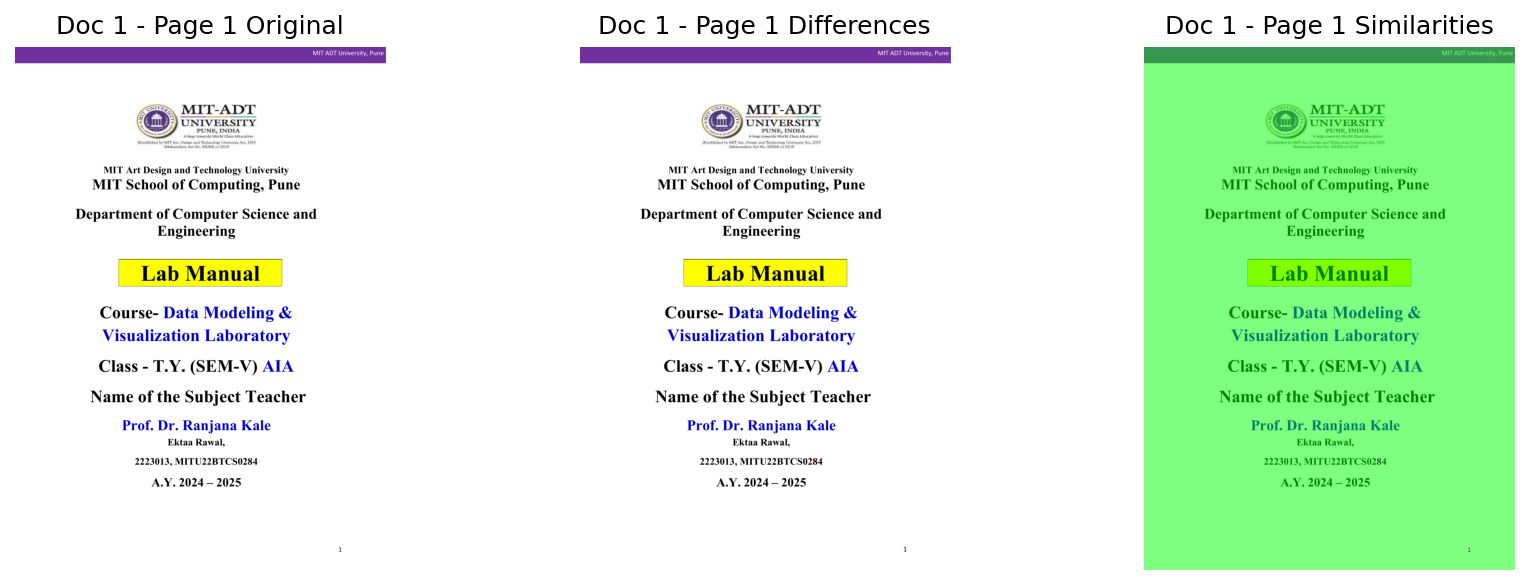

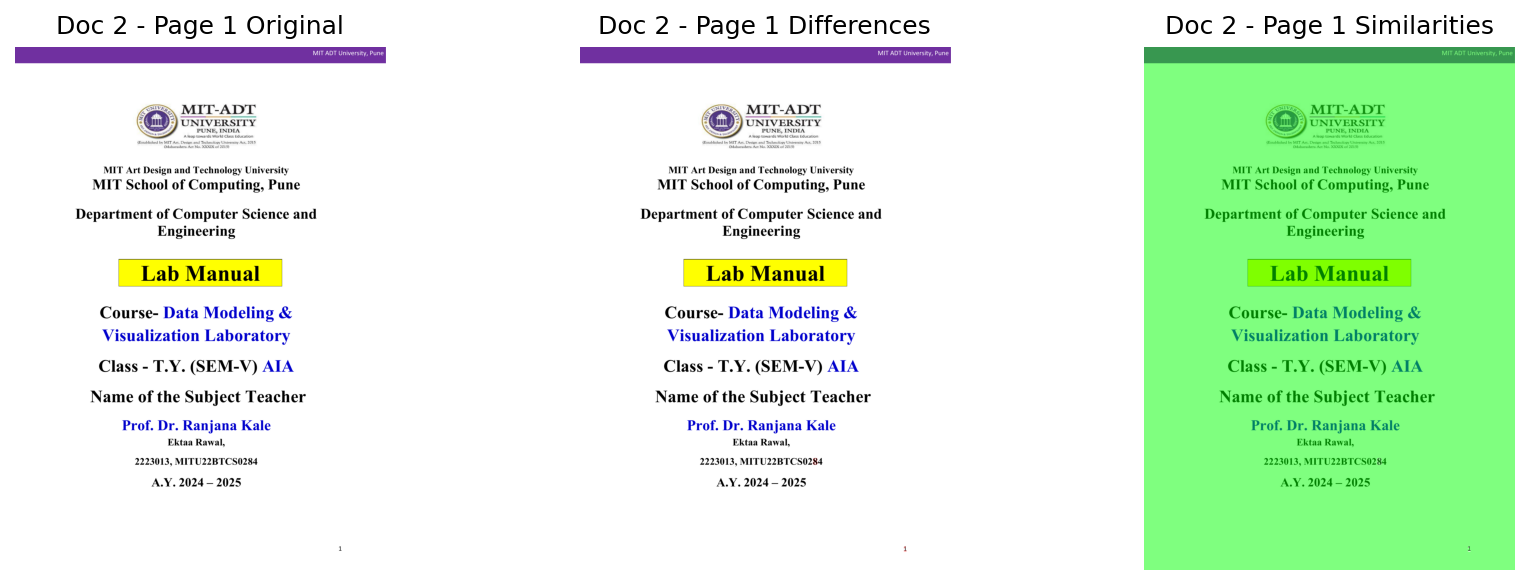

Processing page 2


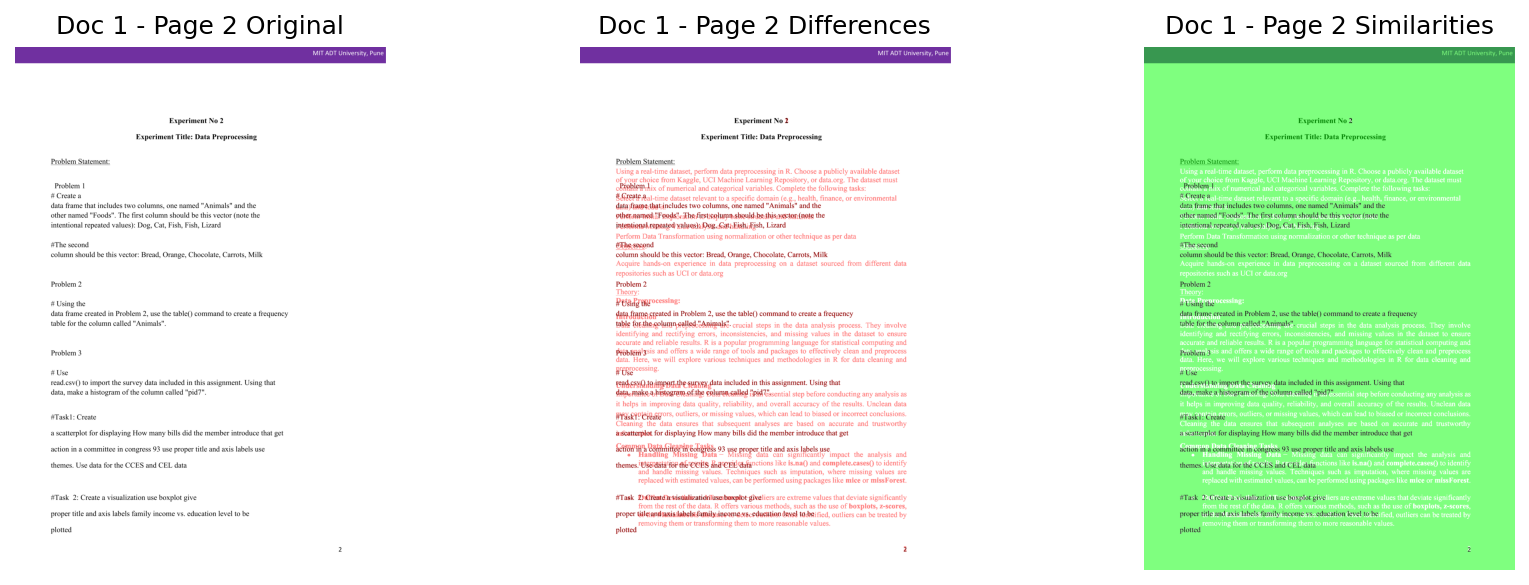

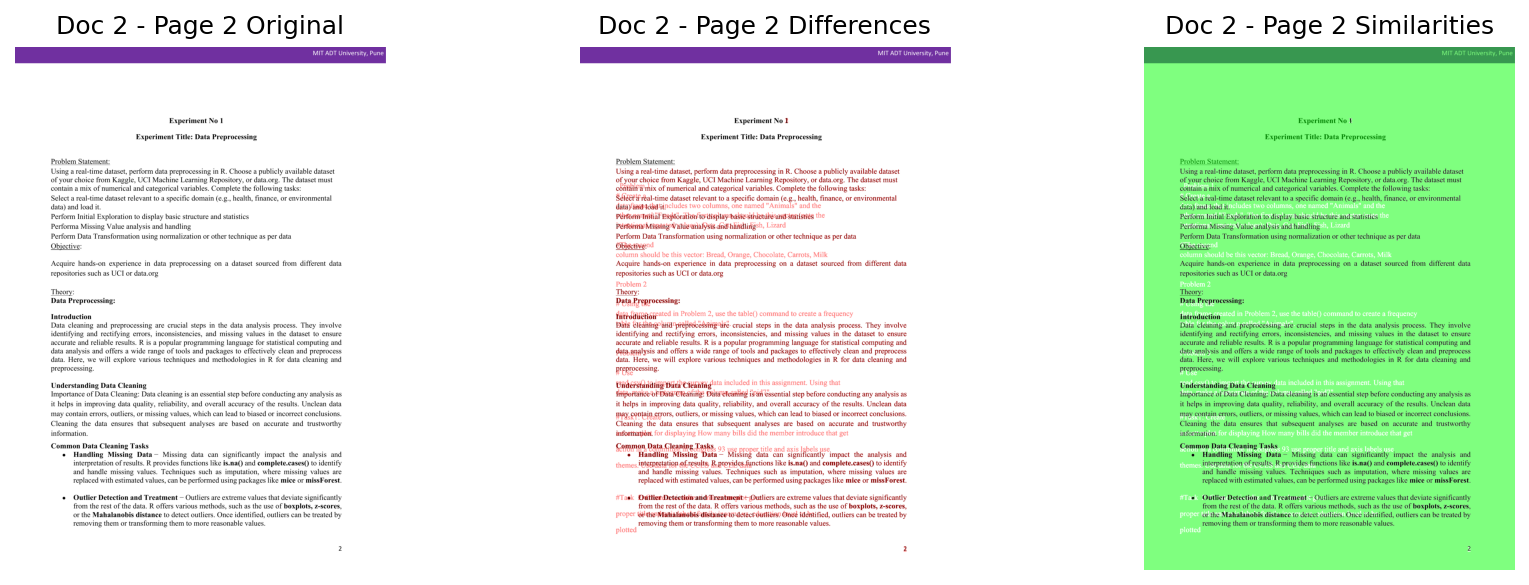

Processing page 3


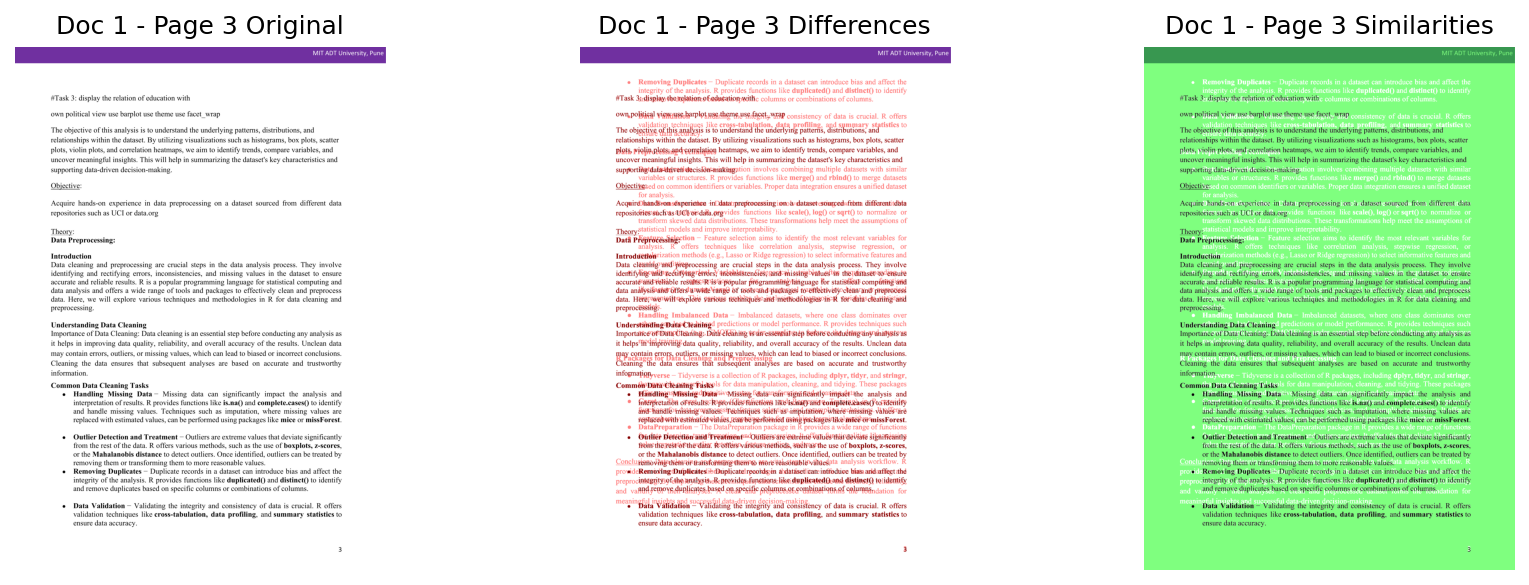

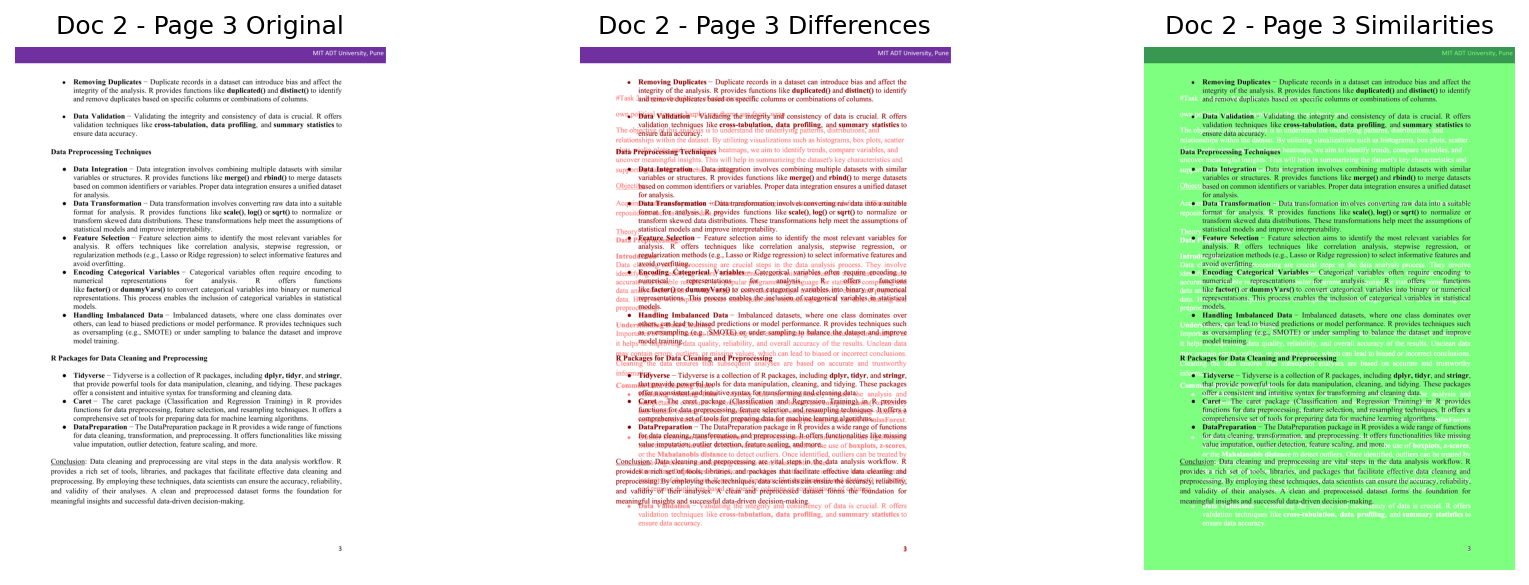

Processing page 4


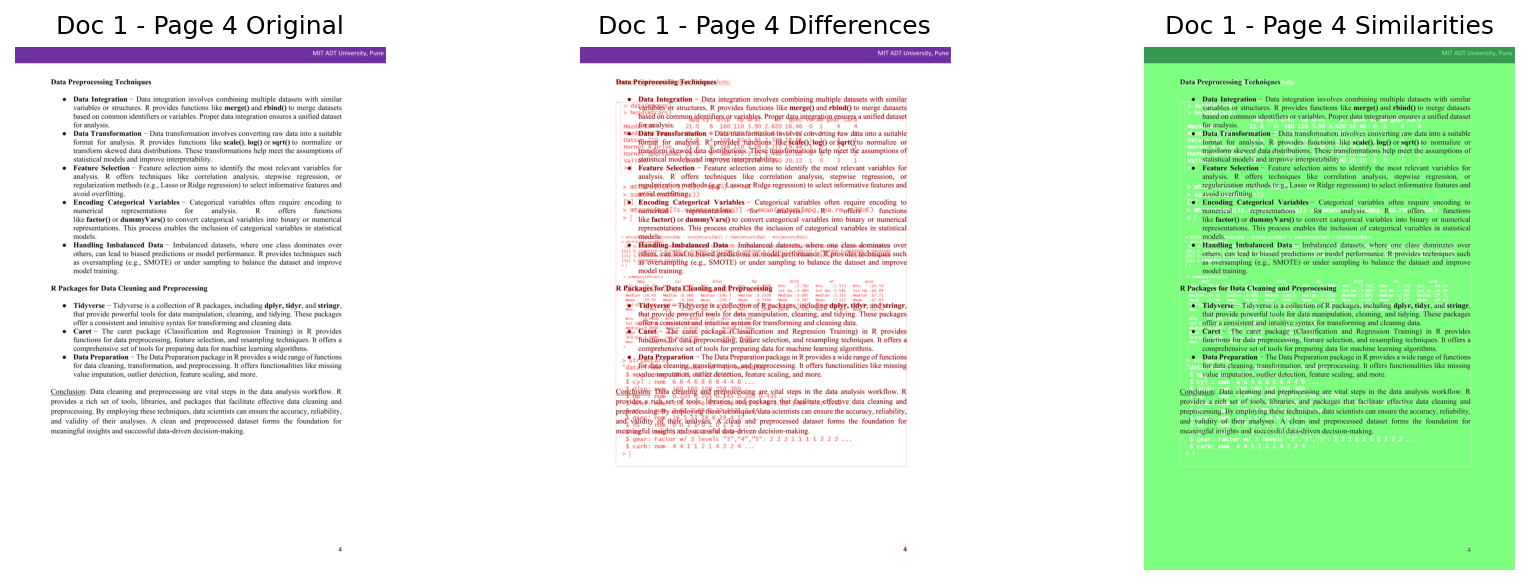

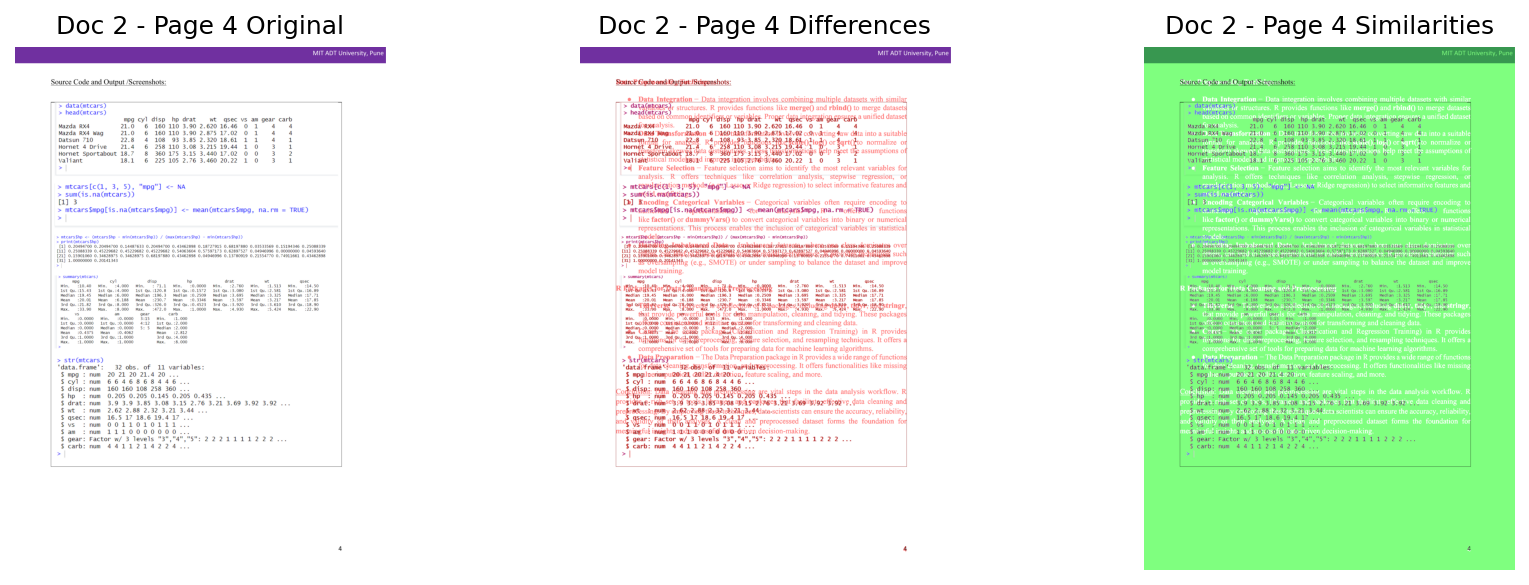

Processing page 5


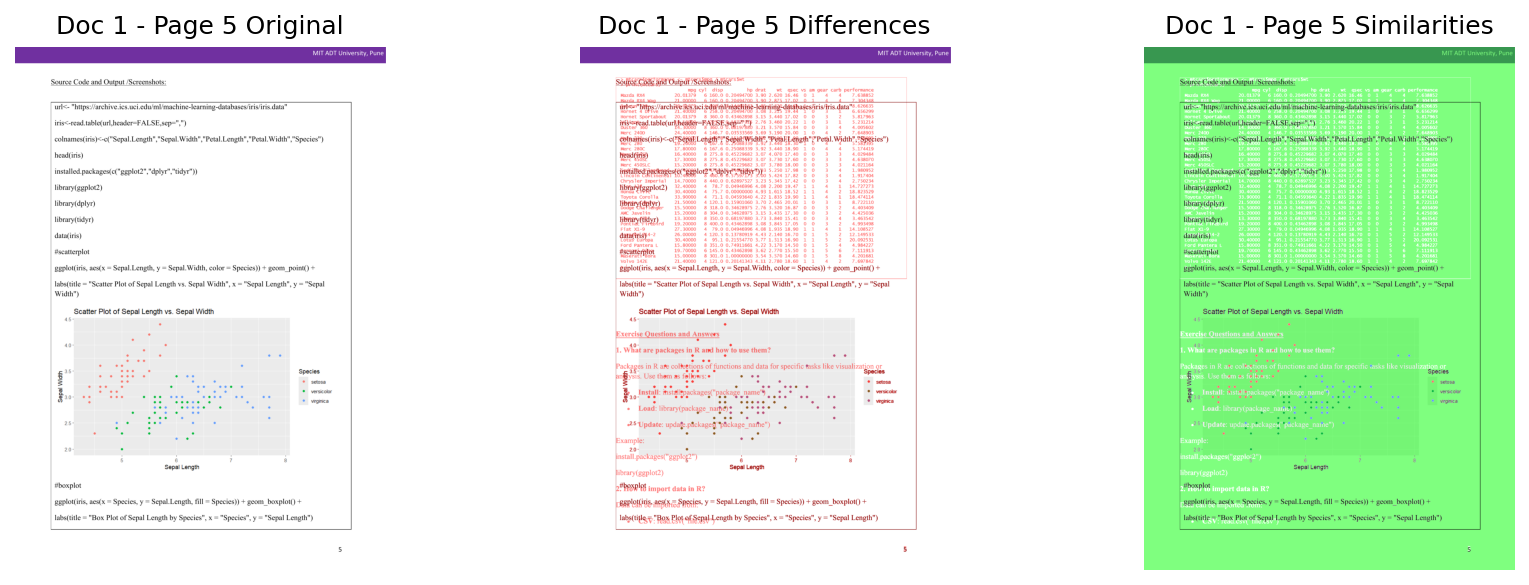

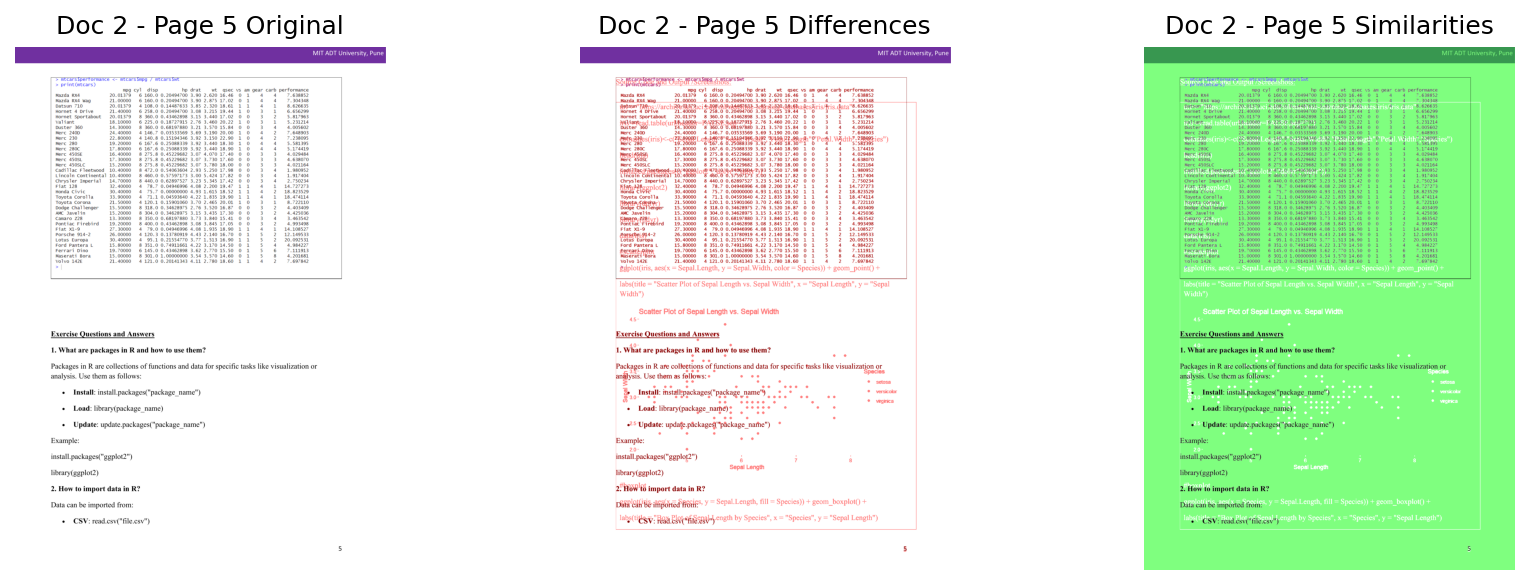

Processing page 6


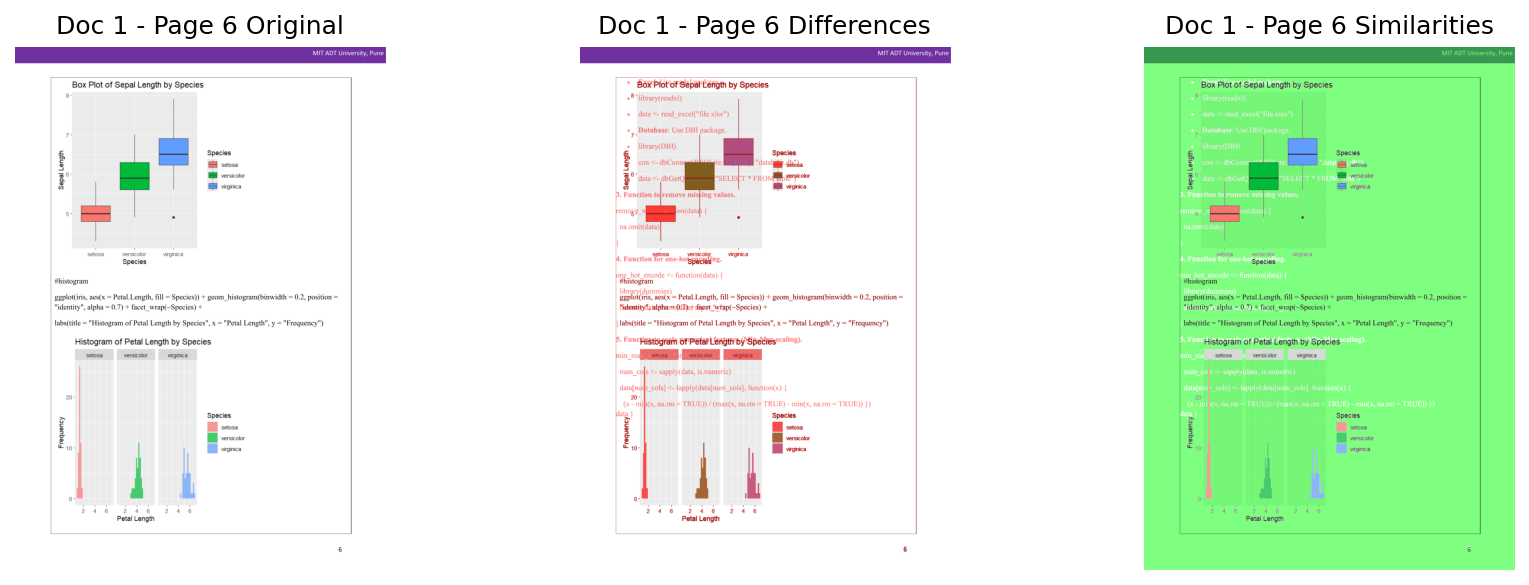

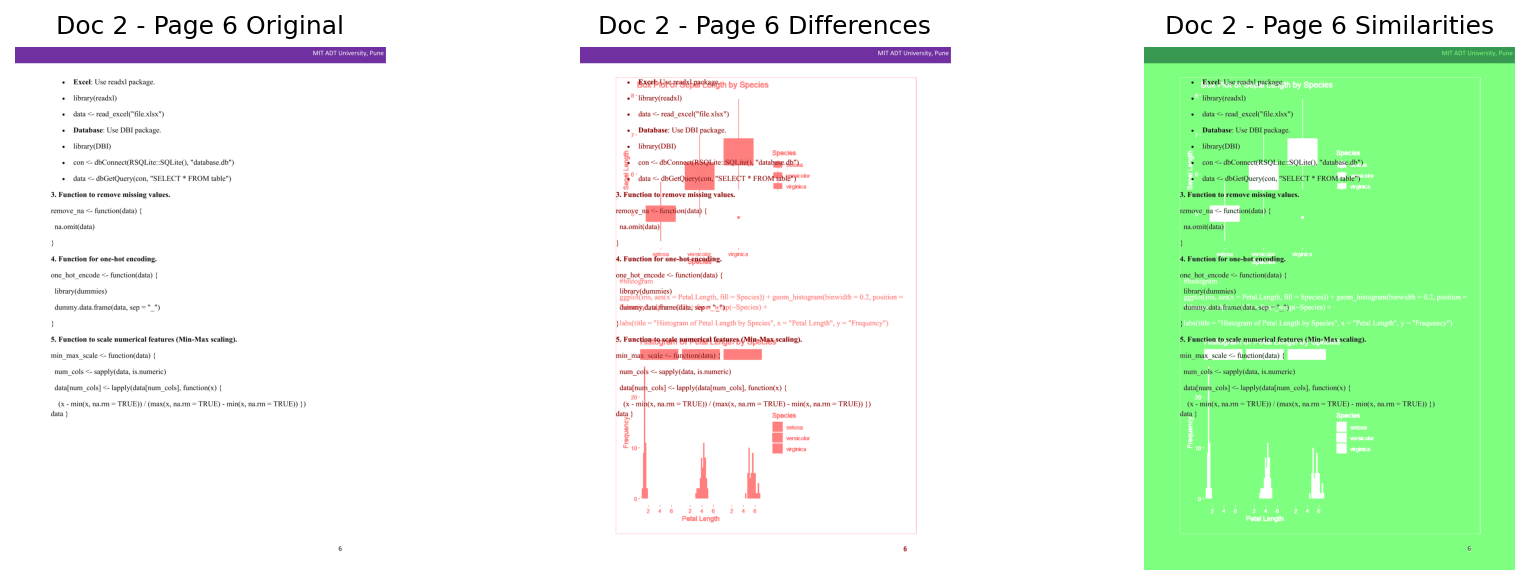

In [6]:
def generate_heatmap(pages1, pages2, threshold=30, alpha=0.5):
    if not isinstance(pages1, list):
        pages1 = [pages1]
    if not isinstance(pages2, list):
        pages2 = [pages2]
    
    # If one document is a single page and the other has more, repeat the single page.
    max_pages = max(len(pages1), len(pages2))
    if len(pages1) == 1 and max_pages > 1:
        print("Repeating pages1 for all pages.")
        pages1 = pages1 * max_pages
    if len(pages2) == 1 and max_pages > 1:
        print("Repeating pages2 for all pages.")
        pages2 = pages2 * max_pages

    # Process the number of pages equal to the minimum of the two.
    n_pages = min(len(pages1), len(pages2))
    print("Total pages to process:", n_pages)
    
    for i in range(n_pages):
        print("Processing page", i+1)
        page1 = pages1[i]
        page2 = pages2[i]
        
        # Convert pages to grayscale arrays.
        img1_gray = np.array(page1.convert("L"))
        img2_gray = np.array(page2.convert("L"))
        
        # Resize page2 if dimensions differ from page1.
        if img1_gray.shape != img2_gray.shape:
            print(f"Resizing page {i+1} of Document 2 to match Document 1.")
            page2 = page2.resize(page1.size)
            img2_gray = np.array(page2.convert("L"))
        
        # Compute absolute difference and create binary masks.
        abs_diff = cv2.absdiff(img1_gray, img2_gray)
        _, diff_mask = cv2.threshold(abs_diff, threshold, 255, cv2.THRESH_BINARY)
        sim_mask = cv2.bitwise_not(diff_mask)
        
        # Convert original pages to RGB.
        img1_rgb = np.array(page1.convert("RGB"))
        img2_rgb = np.array(page2.convert("RGB"))
        
        # Define overlay colors.
        diff_color = np.array([255, 0, 0], dtype=np.uint8)   # red for differences
        sim_color  = np.array([0, 255, 0], dtype=np.uint8)   # green for similarities
        
        # Create copies for overlays.
        diff_overlay1 = img1_rgb.copy()
        sim_overlay1  = img1_rgb.copy()
        diff_overlay2 = img2_rgb.copy()
        sim_overlay2  = img2_rgb.copy()
        
        # Convert masks to boolean arrays.
        mask_diff = diff_mask.astype(bool)
        mask_sim  = sim_mask.astype(bool)
        
        # Apply alpha blending to create overlay images.
        diff_overlay1[mask_diff] = ((1 - alpha) * diff_overlay1[mask_diff] + alpha * diff_color).astype(np.uint8)
        sim_overlay1[mask_sim]   = ((1 - alpha) * sim_overlay1[mask_sim]   + alpha * sim_color).astype(np.uint8)
        
        diff_overlay2[mask_diff] = ((1 - alpha) * diff_overlay2[mask_diff] + alpha * diff_color).astype(np.uint8)
        sim_overlay2[mask_sim]   = ((1 - alpha) * sim_overlay2[mask_sim]   + alpha * sim_color).astype(np.uint8)
        
        # Display results for Document 1 in one figure.
        plt.figure(figsize=(12, 4), dpi=150)
        plt.subplot(1, 3, 1)
        plt.imshow(img1_rgb)
        plt.title(f"Doc 1 - Page {i+1} Original")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(diff_overlay1)
        plt.title(f"Doc 1 - Page {i+1} Differences")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(sim_overlay1)
        plt.title(f"Doc 1 - Page {i+1} Similarities")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        # Display results for Document 2 in a separate figure.
        plt.figure(figsize=(12, 4), dpi=150)
        plt.subplot(1, 3, 1)
        plt.imshow(img2_rgb)
        plt.title(f"Doc 2 - Page {i+1} Original")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(diff_overlay2)
        plt.title(f"Doc 2 - Page {i+1} Differences")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(sim_overlay2)
        plt.title(f"Doc 2 - Page {i+1} Similarities")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

# To call the function, use your global variables (assumed to be loaded in a previous cell):
if 'pages1' in globals() and 'pages2' in globals():
    generate_heatmap(pages1, pages2, threshold=30, alpha=0.5)
else:
    print("Global variables 'pages1' and/or 'pages2' are not defined. Please run the file-loading cell first.")



In [7]:
def compute_overlays(image1, image2, threshold=30, alpha=0.5):
    # Convert images to grayscale.
    img1_gray = np.array(image1.convert("L"))
    img2_gray = np.array(image2.convert("L"))
    
    # If dimensions differ, resize image2 to match image1.
    if img1_gray.shape != img2_gray.shape:
        image2 = image2.resize(image1.size)
        img2_gray = np.array(image2.convert("L"))
    
    # Compute absolute difference and binary mask.
    abs_diff = cv2.absdiff(img1_gray, img2_gray)
    _, diff_mask = cv2.threshold(abs_diff, threshold, 255, cv2.THRESH_BINARY)
    sim_mask = cv2.bitwise_not(diff_mask)
    
    # Convert original images to RGB.
    img1_rgb = np.array(image1.convert("RGB"))
    img2_rgb = np.array(image2.convert("RGB"))
    
    # Define overlay colors.
    diff_color = np.array([255, 0, 0], dtype=np.uint8)   # Red for differences.
    sim_color  = np.array([0, 255, 0], dtype=np.uint8)   # Green for similarities.
    
    # Make copies for overlays.
    diff_overlay1 = img1_rgb.copy()
    sim_overlay1  = img1_rgb.copy()
    diff_overlay2 = img2_rgb.copy()
    sim_overlay2  = img2_rgb.copy()
    
    # Boolean masks.
    mask_diff = diff_mask.astype(bool)
    mask_sim  = sim_mask.astype(bool)
    
    # Apply alpha blending.
    diff_overlay1[mask_diff] = ((1 - alpha) * diff_overlay1[mask_diff] + alpha * diff_color).astype(np.uint8)
    sim_overlay1[mask_sim]   = ((1 - alpha) * sim_overlay1[mask_sim]   + alpha * sim_color).astype(np.uint8)
    diff_overlay2[mask_diff] = ((1 - alpha) * diff_overlay2[mask_diff] + alpha * diff_color).astype(np.uint8)
    sim_overlay2[mask_sim]   = ((1 - alpha) * sim_overlay2[mask_sim]   + alpha * sim_color).astype(np.uint8)
    
    return {
        "image1_original": Image.fromarray(img1_rgb),
        "image1_diff":     Image.fromarray(diff_overlay1),
        "image1_sim":      Image.fromarray(sim_overlay1),
        "image2_original": Image.fromarray(img2_rgb),
        "image2_diff":     Image.fromarray(diff_overlay2),
        "image2_sim":      Image.fromarray(sim_overlay2),
    }

###########################################
# Save overlay images to disk.
###########################################
def save_images(overlays, directory="output_images"):
    """
    Saves the overlay images in the overlays dictionary into the specified directory.
    Returns a dictionary mapping keys to file paths.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    paths = {}
    for key in overlays:
        filepath = os.path.join(directory, f"{key}.png")
        overlays[key].save(filepath)
        paths[key] = filepath
    return paths

###########################################
# Create a DOCX report with a table for each page.
###########################################
def create_docx_report_list(list_of_paths, docx_filename="ImageComparisonReport.docx"):
    """
    Given a list of dictionaries (each with keys:
    'image1_original', 'image1_diff', 'image1_sim',
    'image2_original', 'image2_diff', 'image2_sim'),
    create a DOCX report with one table per page.
    """
    doc = Document()
    doc.add_heading("Image Comparison Report", level=1)
    
    for i, paths in enumerate(list_of_paths):
        doc.add_heading(f"Page {i+1}", level=2)
        table = doc.add_table(rows=1, cols=3)
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = "Type"
        hdr_cells[1].text = "File 1"
        hdr_cells[2].text = "File 2"
        
        def add_row(type_text, path1, path2):
            row_cells = table.add_row().cells
            row_cells[0].text = type_text
            row_cells[1].paragraphs[0].add_run().add_picture(path1, width=Inches(2))
            row_cells[2].paragraphs[0].add_run().add_picture(path2, width=Inches(2))
        
        add_row("Original", paths["image1_original"], paths["image2_original"])
        add_row("Unique (Differences)", paths["image1_diff"], paths["image2_diff"])
        add_row("Common (Similarities)", paths["image1_sim"], paths["image2_sim"])
        doc.add_paragraph("")  # add space between tables
    doc.save(docx_filename)
    print(f"Report saved as '{docx_filename}'")

###########################################
# Main processing: Compute overlays for each page and generate a DOCX report.
###########################################

# Ensure that pages1 and pages2 are defined (from your file-loading cell).
if 'pages1' not in globals() or 'pages2' not in globals():
    print("Global variables 'pages1' and/or 'pages2' are not defined. Please run the file-loading cell first.")
else:
    # If one document is single page and the other has multiple pages, repeat the single page.
    if len(pages1) == 1 and len(pages2) > 1:
        pages1 = pages1 * len(pages2)
    if len(pages2) == 1 and len(pages1) > 1:
        pages2 = pages2 * len(pages1)
    
    n = min(len(pages1), len(pages2))
    print(f"Processing overlays for {n} page pair(s)...")
    overlay_list = []  # to hold the file paths for each page's overlays.
    
    for i in range(n):
        print(f"Processing page {i+1}...")
        overlays = compute_overlays(pages1[i], pages2[i], threshold=30, alpha=0.5)
        # Save the overlays for this page in a subdirectory (e.g., output_images/page_1, etc.)
        directory = os.path.join("output_images", f"page_{i+1}")
        saved_paths = save_images(overlays, directory=directory)
        overlay_list.append(saved_paths)
    
    # Create a DOCX report that includes a table for each page.
    create_docx_report_list(overlay_list, docx_filename="ImageComparisonReport.docx")


Processing overlays for 6 page pair(s)...
Processing page 1...
Processing page 2...
Processing page 3...
Processing page 4...
Processing page 5...
Processing page 6...
Report saved as 'ImageComparisonReport.docx'


In [8]:
print("\n🔹 Document Comparison Results 🔹")
print(f"1️⃣ Overall CLIP Cosine Similarity: {overall_cosine:.4f}")
print(f"2️⃣ Overall Structural Similarity Score (SSIM): {overall_ssim:.4f}")

if overall_cosine > 0.8 and overall_ssim > 0.8:
    print("\n✅ The documents are very similar.")
elif overall_cosine > 0.5 or overall_ssim > 0.5:
    print("\n⚠️ The documents have some similarities but also differences.")
else:
    print("\n❌ The documents are quite different.")



🔹 Document Comparison Results 🔹
1️⃣ Overall CLIP Cosine Similarity: 0.9452
2️⃣ Overall Structural Similarity Score (SSIM): 0.7721

⚠️ The documents have some similarities but also differences.
